<a href="https://colab.research.google.com/github/magjanvaz/curso-python-us/blob/main/notebooks/practicas/Regression_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Construyendo un modelo de regresión lineal

En esta sección vamos a utilizar un dataset sobre el precio de la vivienda en el estado de California para construir un modelo de regresión con la librería `sklearn` haciendo uso de sus clases predefinidas para modelos y procesamiento, apoyándonos como es usual en `numpy`, `pandas` y `matplotlib`. 

## Imports y configuraciones 

En primer lugar, vamos a importar algunos módulos, configurar cómo se renderizan las figuras de matplotlib para que se vean bien en la página y hacer algunas comprobaciones sobre el versionado de las librerías utilizadas. Definimos una función para guardar imágenes en caso de que queramos persisitir alguna de ellas.

In [1]:
%config InlineBackend.figure_format='retina'

In [2]:
# Python ≥3.5 is required 
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# To plot pretty figures

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams["figure.figsize"] = (12, 8)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Descargando los datos 

La siguiente función descarga y descomprime los datos de viviendas desde una URL específica a una ruta específica en el sistema de archivos. Si la ruta no existe, la función la crea. Después, descarga un archivo .tgz de la URL especificada y lo descomprime en la ruta especificada.

In [3]:
import os
import tarfile
import urllib.request

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [4]:
fetch_housing_data()

Ahora utilizamos la función `pd.read_csv` de pandas para leer un `.csv` cuya ruta hay que especificar 

In [5]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [6]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


Echemos un vistazo rápido a la información disponible sobre este dataframe

In [12]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   longitude           20640 non-null  float64 
 1   latitude            20640 non-null  float64 
 2   housing_median_age  20640 non-null  float64 
 3   total_rooms         20640 non-null  float64 
 4   total_bedrooms      20433 non-null  float64 
 5   population          20640 non-null  float64 
 6   households          20640 non-null  float64 
 7   median_income       20640 non-null  float64 
 8   median_house_value  20640 non-null  float64 
 9   ocean_proximity     20640 non-null  category
dtypes: category(1), float64(9)
memory usage: 1.4 MB


Tenemos 9 columnas numéricas, una columna categórica y un total de 20640 filas. **Nuestro objetivo será predecir la variable `median_house_value`** cuando dispongamos del resto de columnas para un barrio nuevo. Veamos qué posibles valores tiene la columna tipo `object` llamada `ocean_proximity`

In [8]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

Vamos con el resto de columnas numéricas 

In [9]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Parece razonable proponer el siguiente ejercicio 

:::{exercise}
:label: regression-model-1

Convierte la columna `ocean_proximity` en categórica y las columnas susceptibles de ser de tipo entero. Recuerda que las columnas que tienen valores faltantes no pueden ser convertidas en tipo entero. 

:::

In [11]:
housing = housing.astype({
    "ocean_proximity": "category"
    # "total_bedrooms": "int"
    # esto no podemos porque tiene valores NA
})

Vamos a representar el historgrama de las variables numéricas de nuestro dataframe. Para ello basta llamar al método `hist` de `pd.DataFrame`

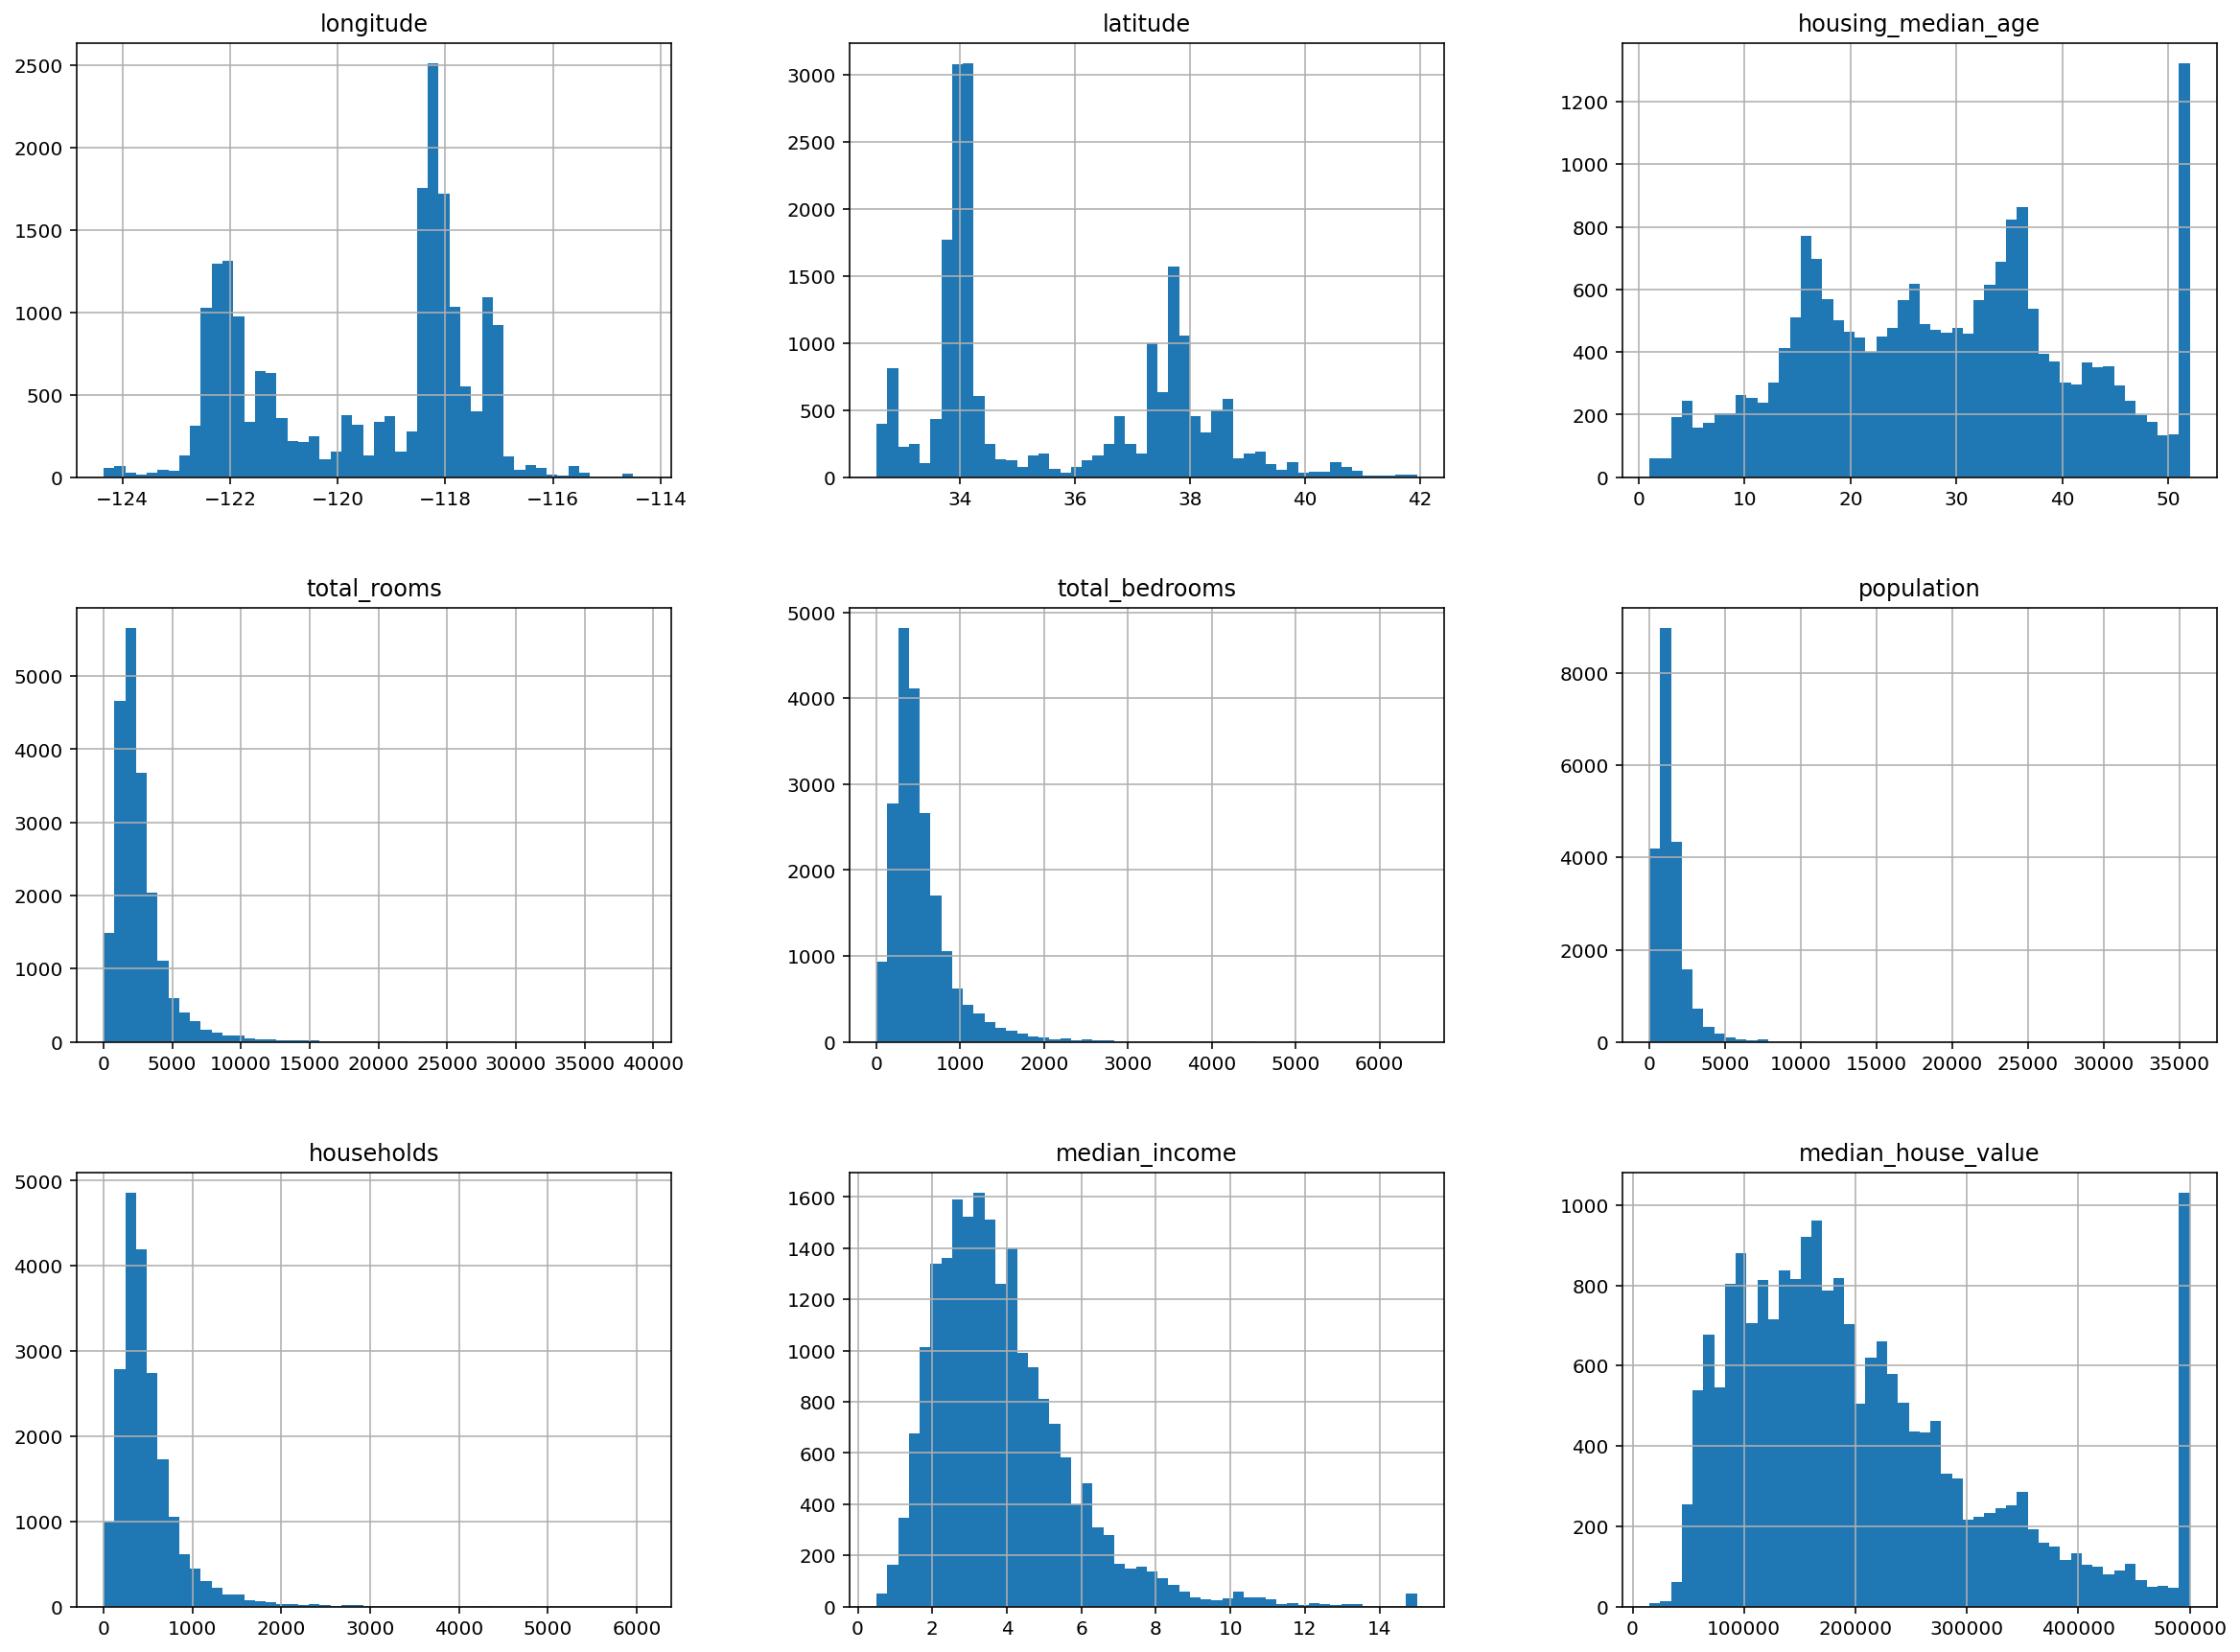

In [13]:
housing.hist(bins=50, figsize=(20,15))
plt.show()

:::{exercise}
:label: regression-model-2

¿Qué conclusiones puedes sacar de estos datos? ¿Cómo podemos proceder?

:::

Podemos ver que en dos de los histogramas al llegar al tope se acumulan una gran cantidad de casas. Debe haberse tomado en ese valor todos los que lo superasen, pero esto no es del todo correcto. Si fuera posible convendría averiguar el valor real, y si no es posible podríamos eliminar la mayor parte para que no creen información incorrecta en nuestro modelo. 

## Creando un conjunto de test

La siguiente función hace una partición entre conjunto de entrenamiento y test de forma similar a `train_test_split` de `sklearn.model_selection`.

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [16]:
train_set, test_set = split_train_test(housing, 0.2)
print(len(train_set))
print(len(test_set))

16512
4128


:::{exercise}
:label: regression-model-3

¿Qué problemas puede tener una partición de este tipo? ¿Cómo podemos solventarlo? Véase [`StratifiedShuffleSplit`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html)

:::

Al hacer una partición aleatoria, puede que las variables categóricas no tengan una distribución similar a la original en cada muestra, y esto es un problema. Ahí mismo tenemos una solución a este problema.

Debemos dejar el conjunto de test apartado antes de hacer cualquier transformación y una vez hayamos concluido la tarea de desarrollar modelos de predicción, podremos usarlo para evaluar dichos modelos. Antes de seguir, vamos a visualizar los datos de los que disponemos para obtener más información de cara a diseñar procesamiento y entrenamiento de modelos. 

In [17]:
housing = train_set.copy()

## Visualizando los datos

Realicemos un gráfico de tipo scatter para representar la información geográfica (longitud y latitud) del dataset.

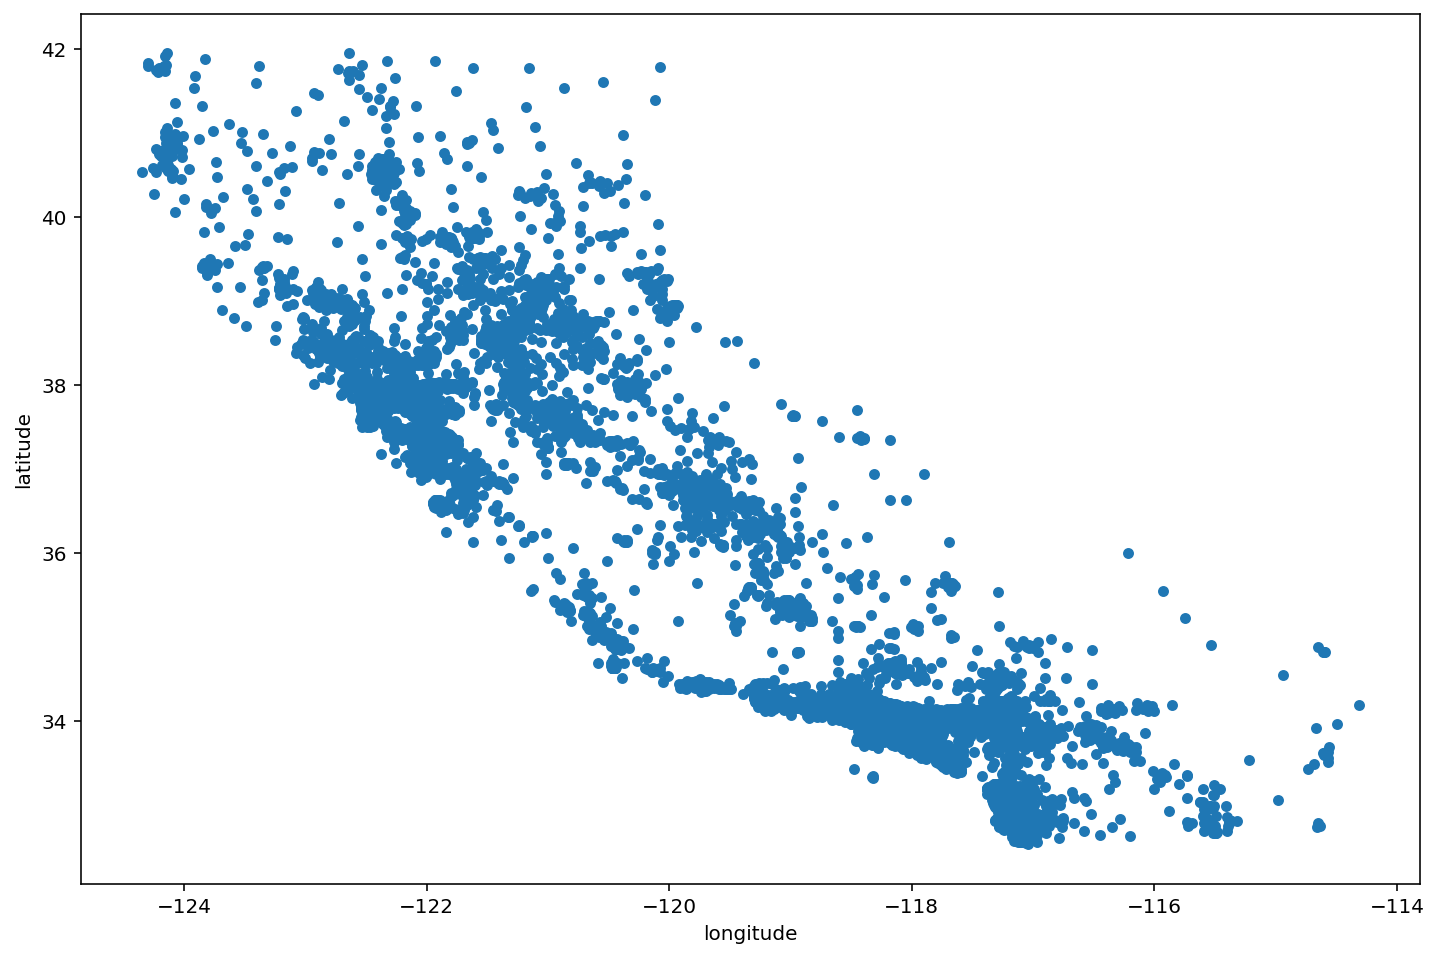

In [18]:
housing.plot(kind="scatter", x="longitude", y="latitude")
plt.show()

Vamos a incluir un poco de transparencia en los puntos para poder apreciar las zonas con mayor densidad 

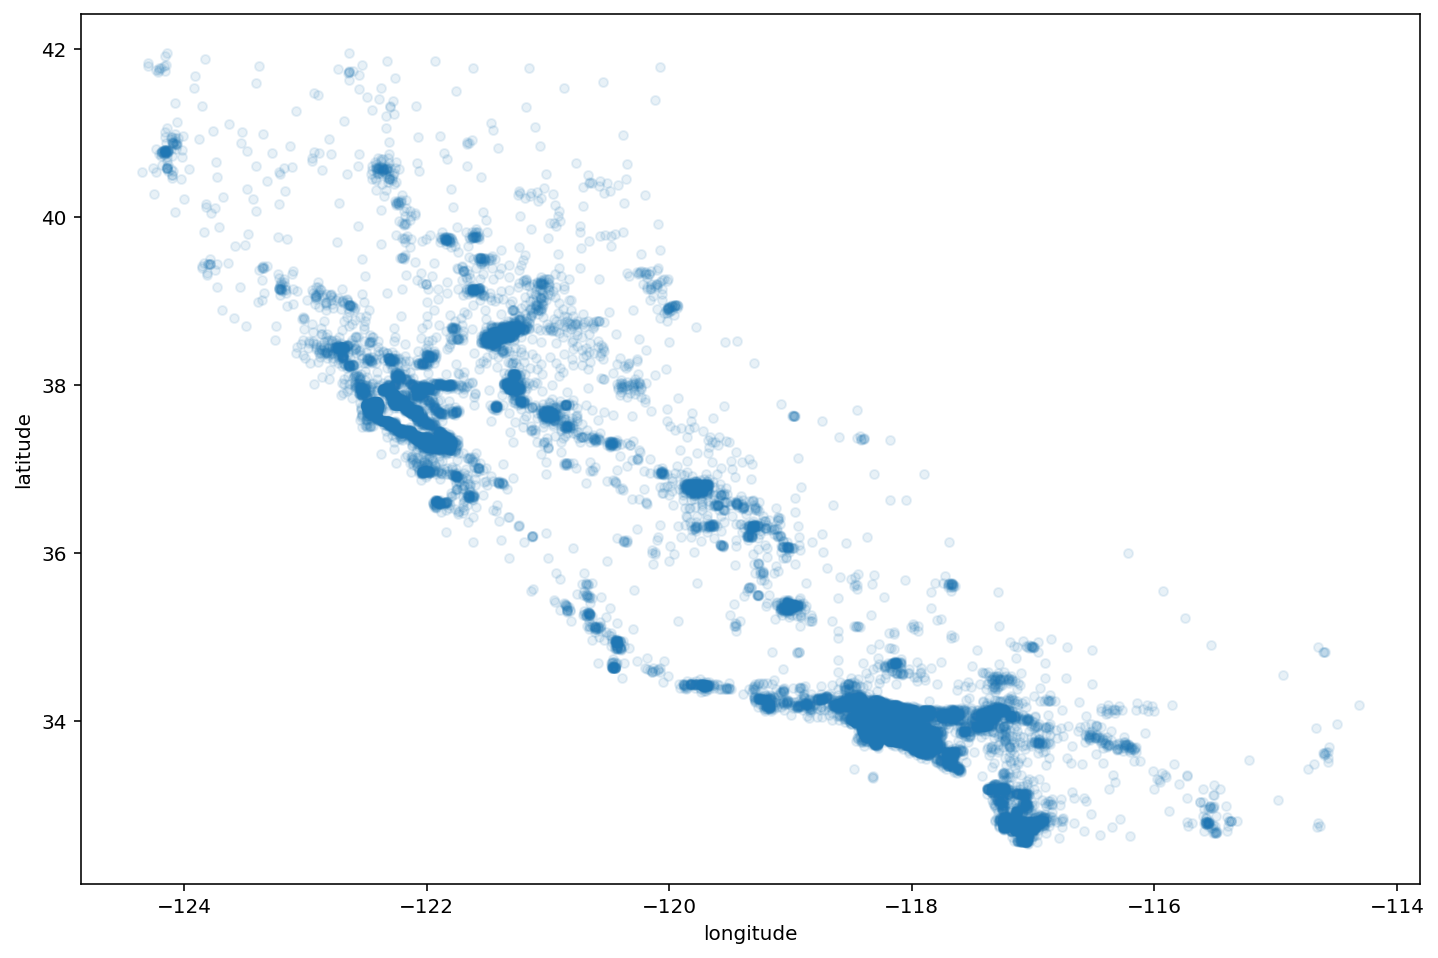

In [19]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)
plt.show()

Ahora añadimos opciones para que el tamaño de cada punto venga en función de la población del distrito y añadimos una barra de color para el precio mediano (variable objetivo)

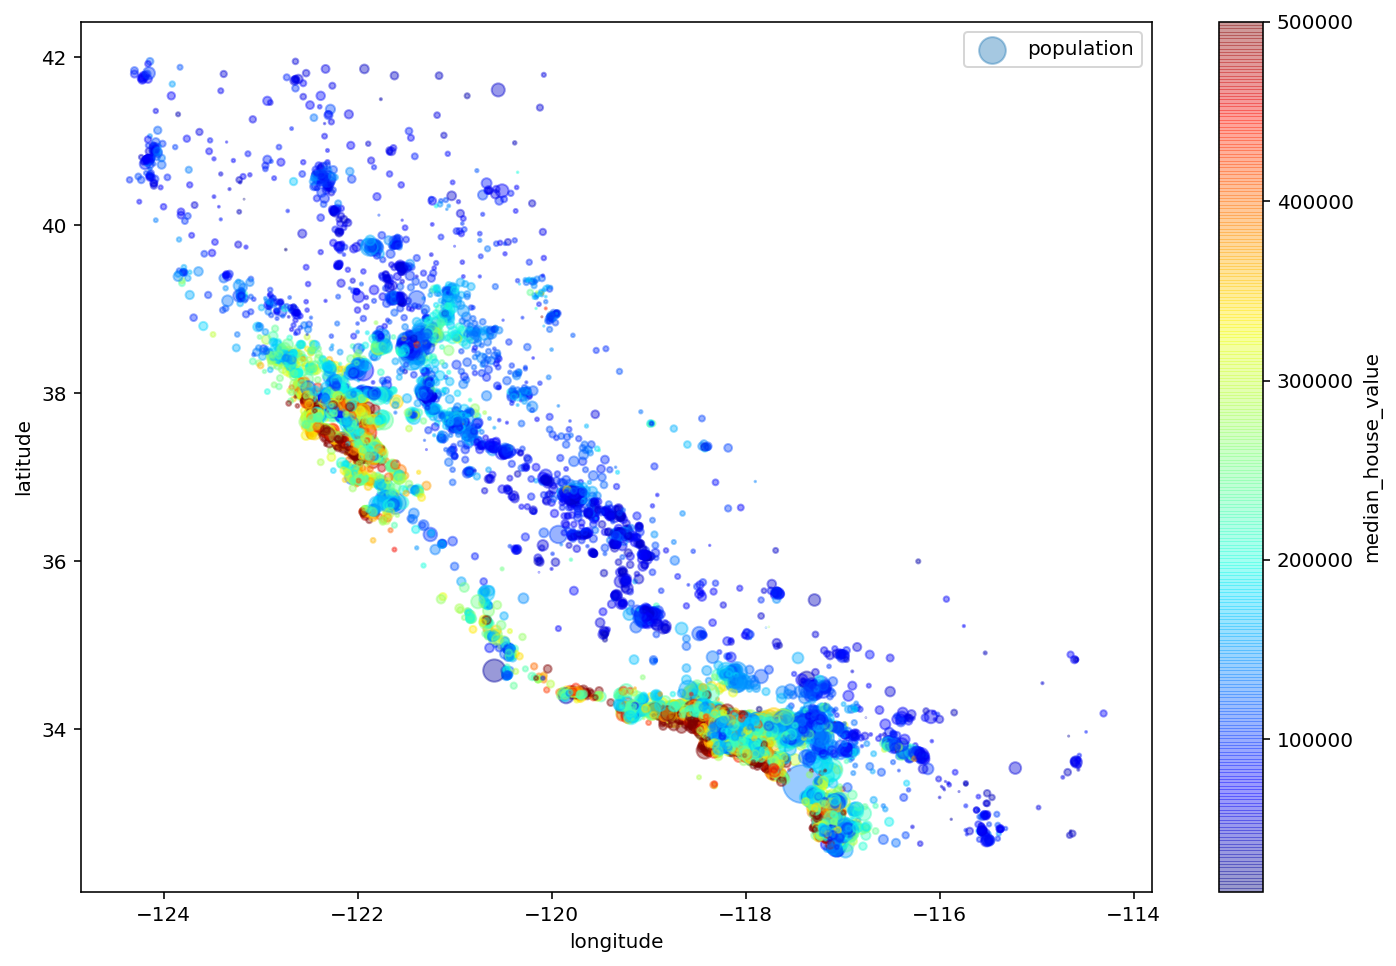

In [20]:
housing.plot(
    kind="scatter", 
    x="longitude", 
    y="latitude", 
    alpha=0.4,
    s=housing["population"]/100, # size
    label="population",
    c="median_house_value",  # colour
    cmap=plt.get_cmap("jet"),   # mapa de calor
    colorbar=True,
    sharex=False
)
plt.legend()
plt.show()

A continuación descargamos una imagen del mapa de california 

In [21]:
# Download the California image
images_path = os.path.join(PROJECT_ROOT_DIR, "images", "end_to_end_project")
os.makedirs(images_path, exist_ok=True)
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
filename = "california.png"
print("Downloading", filename)
url = DOWNLOAD_ROOT + "images/end_to_end_project/" + filename
urllib.request.urlretrieve(url, os.path.join(images_path, filename))

('./images/end_to_end_project/california.png',
 <http.client.HTTPMessage at 0x7f351423be20>)

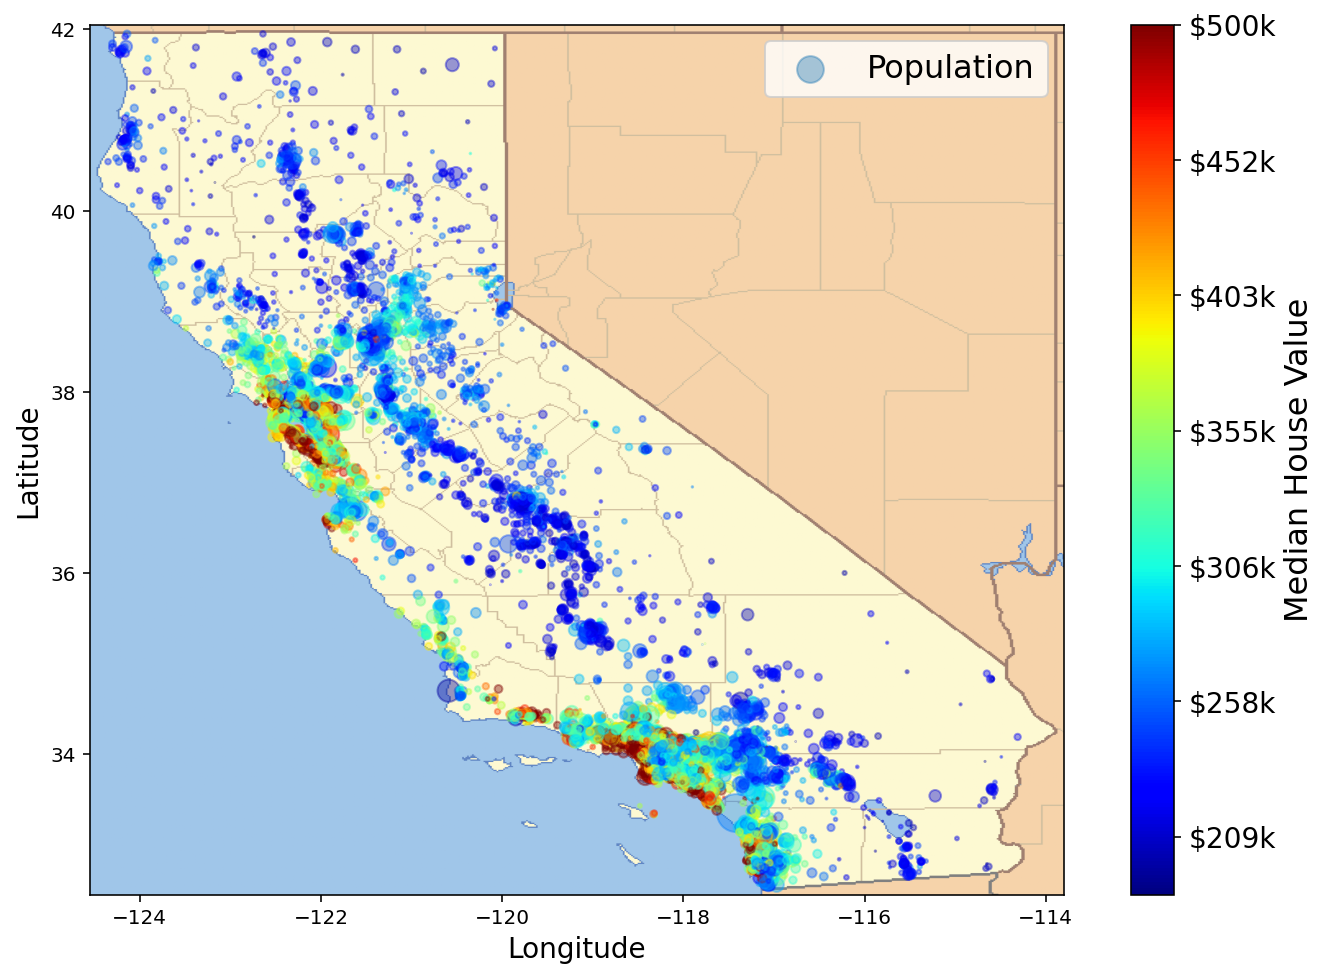

In [22]:
import matplotlib.image as mpimg

california_img=mpimg.imread(os.path.join(images_path, filename))
housing.plot(
    kind="scatter", 
    x="longitude", 
    y="latitude", 
    s=housing['population']/100, 
    label="Population",       
    c="median_house_value", 
    cmap=plt.get_cmap("jet"),         
    colorbar=False, 
    alpha=0.4
)
plt.imshow(
    california_img, 
    extent=[-124.55, -113.80, 32.45, 42.05], 
    alpha=1,
    cmap=plt.get_cmap("jet")
)
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar(ticks=tick_values/prices.max())
cbar.ax.set_yticklabels([f"${round(v/1000)}k" for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
# save_fig("california_housing_prices_plot")
plt.show()

:::{exercise}
:label: regression-model-4

Saca conclusiones del anterior gráfico.

:::

## Profundizando en los datos 

### Correlaciones 
Vamos a calcular la matriz de correlaciones de las variables numéricas del dataframe

In [23]:
corr_matrix = housing.corr()

Veamos cómo de correlacionan las variables regresoras con la objetivo 

In [24]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.689638
total_rooms           0.138369
housing_median_age    0.103382
households            0.069872
total_bedrooms        0.053281
population           -0.021392
longitude            -0.046260
latitude             -0.144866
Name: median_house_value, dtype: float64

La función `heatmap` de la librería **seaborn** (basada en matplotlib) nos puede servir para visualizar la matriz de correlaciones

In [25]:
import seaborn as sns

def create_corr_mat_plot(corr_matrix, ax: plt.Axes) -> None:    
    sns.heatmap(corr_matrix, annot=True, ax=ax, linewidths=0.2, fmt=".2f")
    ax.set_title("Matrix de correlación variables numéricas")

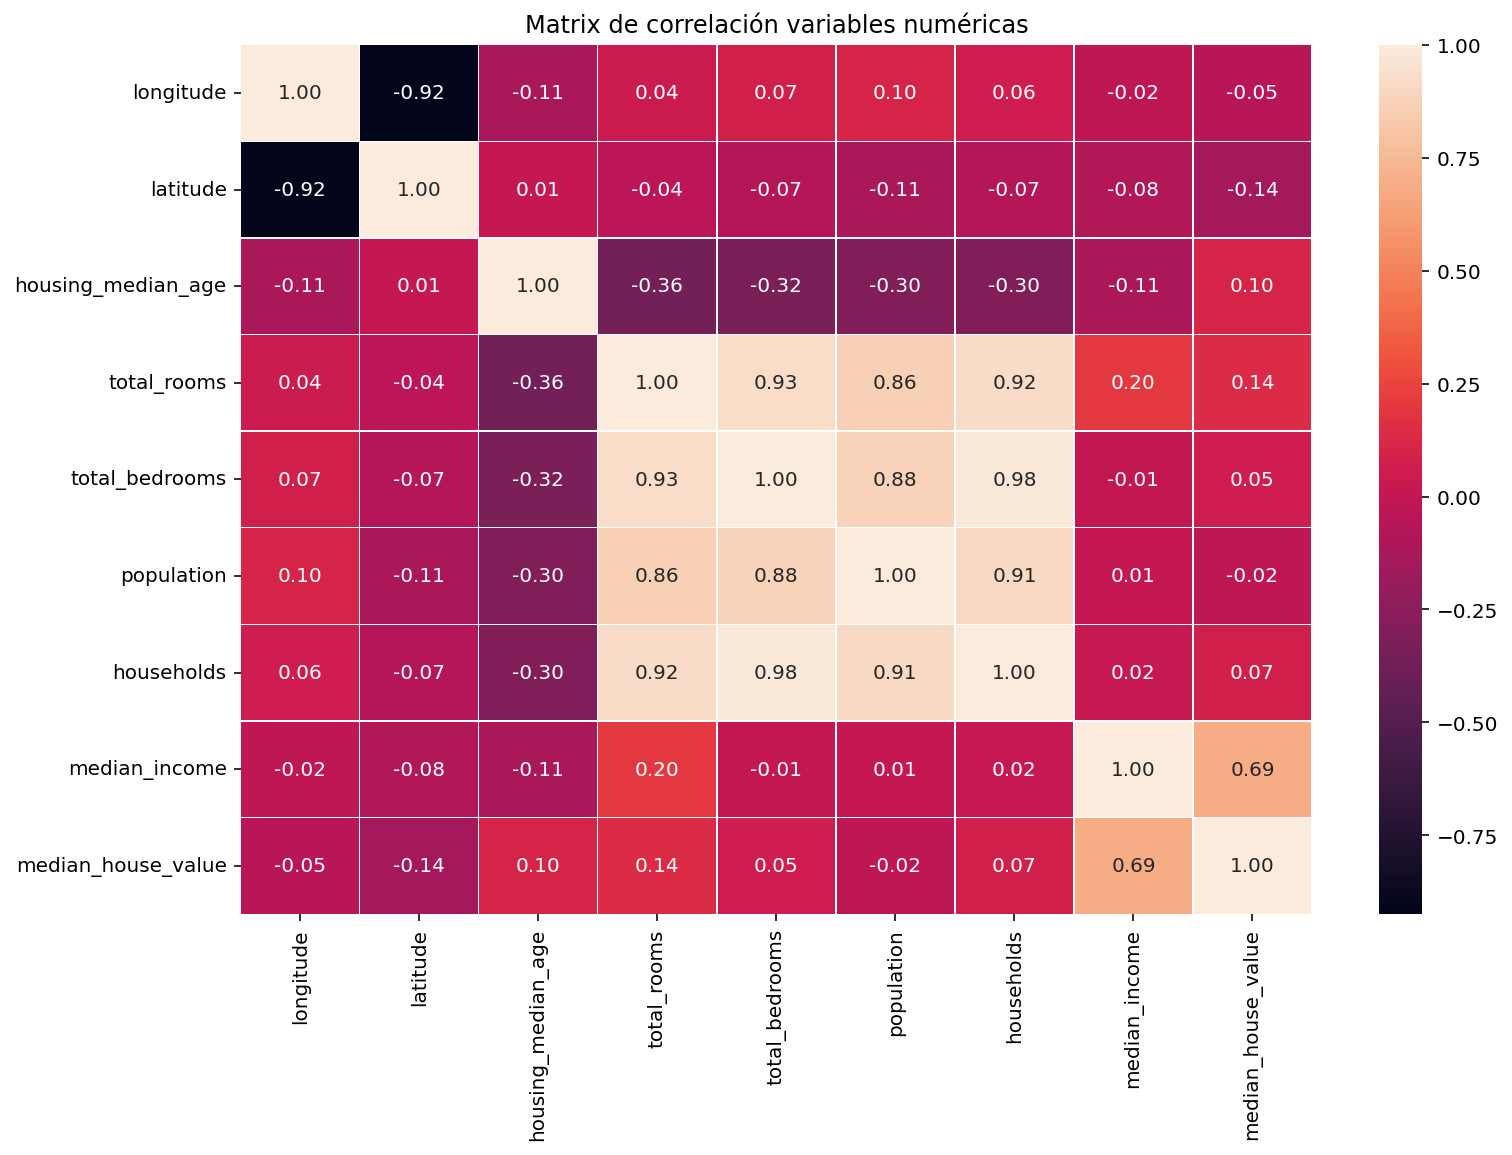

In [26]:
fig, ax = plt.subplots()
create_corr_mat_plot(corr_matrix, ax)
plt.show()

También podemos usar la función `scatter_matrix` de `pandas.plotting` para hacer un scatter plot de los atributos más correlacionados con la variable objetivo 

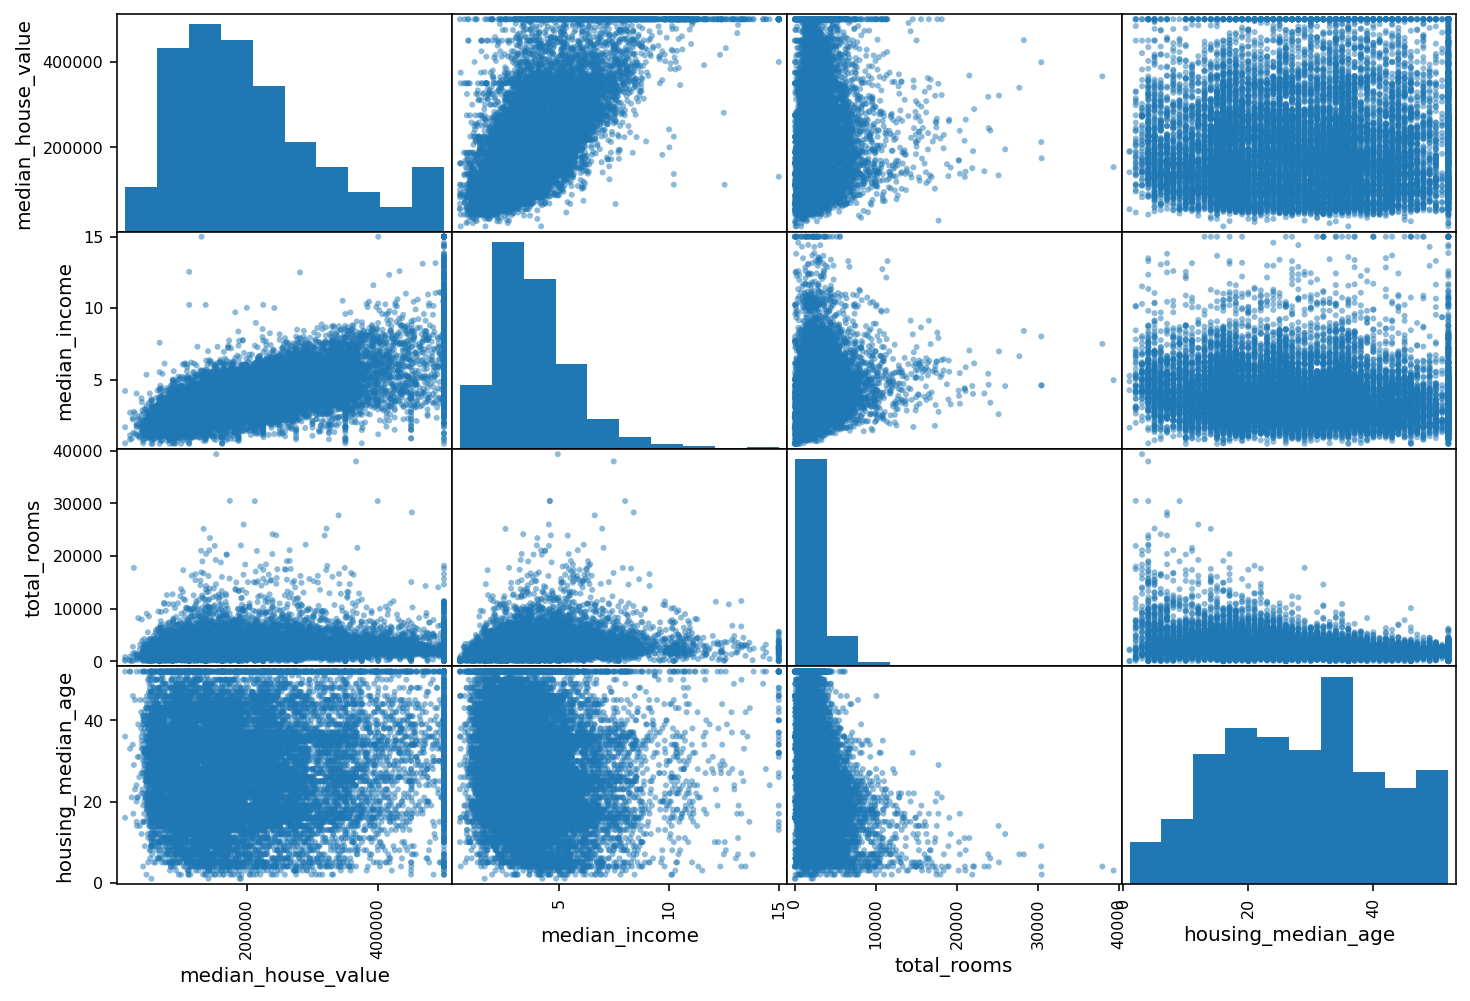

In [27]:
from pandas.plotting import scatter_matrix

attributes = (
    corr_matrix["median_house_value"]
    .sort_values(ascending=False)
    .iloc[:4]
    .index
)
scatter_matrix(housing[attributes], figsize=(12, 8))
plt.show()

Hagamos zoom en el plot de la variable más correlacionada con `median_house_value`

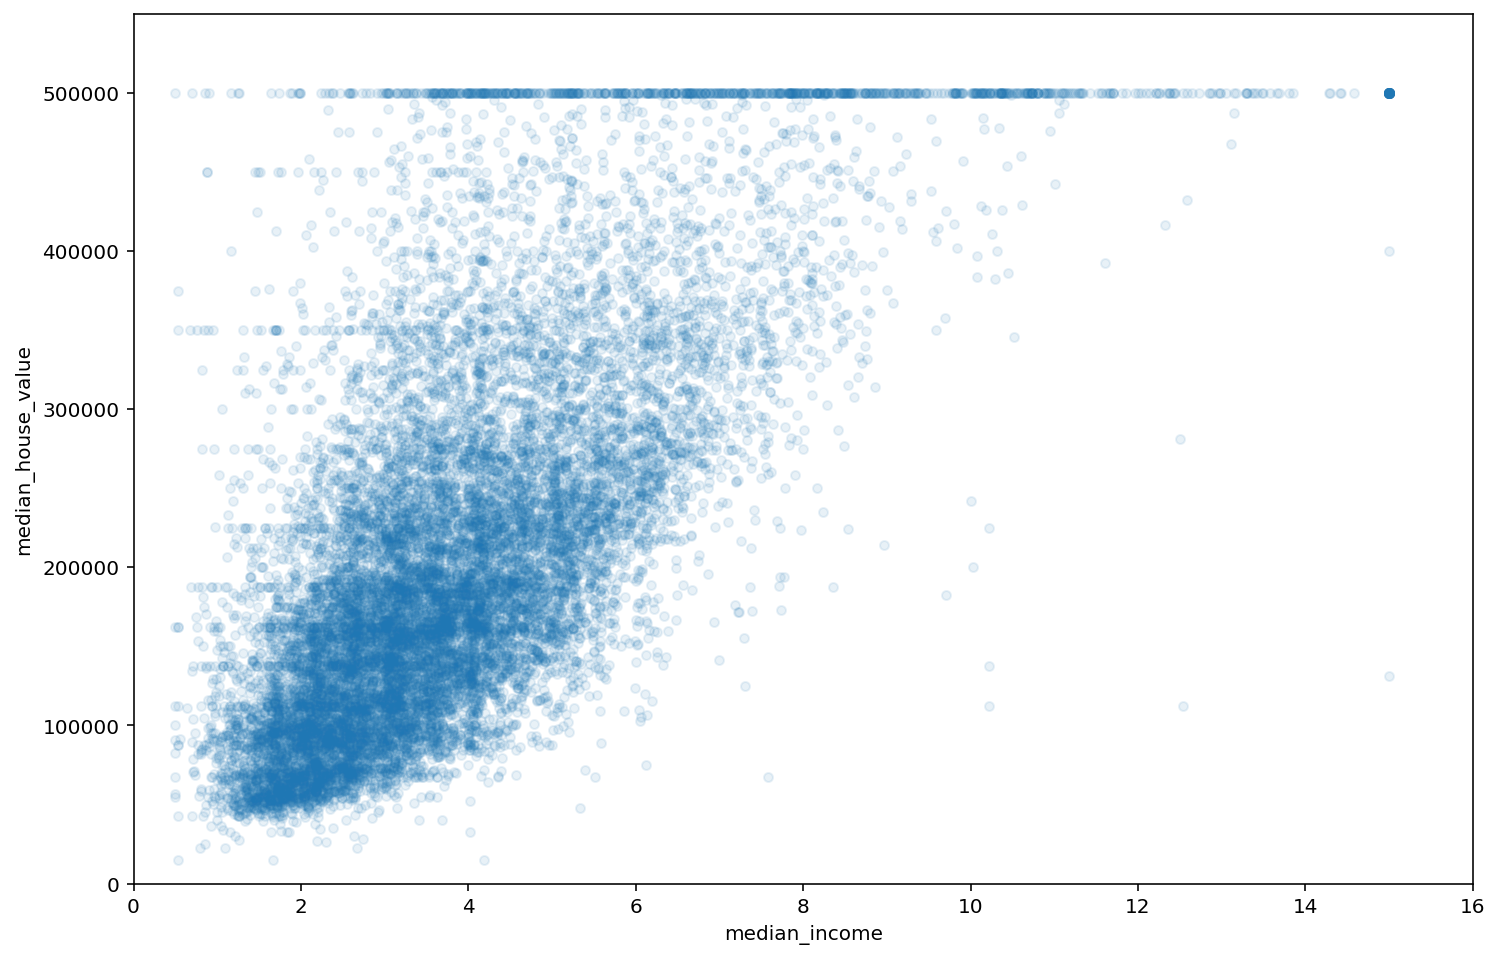

In [28]:
housing.plot(
    kind="scatter", 
    x="median_income", 
    y="median_house_value",
    alpha=0.1
)
plt.axis([0, 16, 0, 550000])
plt.show()

Vemos como efectivamente hay una correlación positiva entre ambas variables y el corte en el valor mediano de las viviendas en 500.000 que habíamos notado en el histograma. Pero también hay un par de líneas horizontales cerca de los 350.000 y 450.000 que no habíamos notado antes, ni tampoco se visualizan en el resto de gráficas de tipo scatter.

In [ ]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 15048 to 16947
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16356 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   median_house_value  16512 non-null  float64
 9   ocean_proximity     16512 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.4+ MB


## Generación de nuevas variables

Un paso muy importante en el procesamiento de datos que alimentan a un modelo es la combinación de atributos para generar nuevas variables que puedan mejorar el rendimiento del mismo.

En este caso por ejemplo tenemos el número total de habitaciones en un distrito (variable `total_rooms`) y también el número total de cuartos `total_bedrooms`, pero parece razonable que otros atributos, como el número de habitaciones por casa o el ratio de cuartos por habitación podrían tener más sentido. Vamos a definirlos  

:::{exercise}
:label: regression-model-5

Define las siguientes columnas de `housing` 

- `rooms_per_household`: número de habitaciones por vivienda
- `bedrooms_per_room`: número de cuartos por habitación
- `population_per_household`: habitantes por vivienda

:::

:::{solution} regression-model-5
:class: dropdown

```
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]
```

:::


In [29]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [30]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.689638
rooms_per_household         0.145165
total_rooms                 0.138369
housing_median_age          0.103382
households                  0.069872
total_bedrooms              0.053281
population                 -0.021392
population_per_household   -0.027166
longitude                  -0.046260
latitude                   -0.144866
bedrooms_per_room          -0.256091
Name: median_house_value, dtype: float64

Parece que las variables `rooms_per_household` y `bedrooms_per_room` tienen grados de correlación superiores a los de las variables originales. 

## Preparando los datos para un modelo de ML

Una vez realizado el análisis de los datos, el procesado de los mismos para alimentar nuestro modelo de ML podría constar de las siguientes partes 

- Limpieza de datos 
- Codificación de variables de texto y categóricas 
- Ingeniería de variables 
- Escalado de variables

Esta secuencia de procesos puede cambiar en función de las particularidades de nuestros datos y el objetivo del modelo. Vamos a ir tratando una a una, pero antes es importante dejar nuestra variable objetivo desacoplada del procesamiento 

In [31]:
housing = train_set.drop("median_house_value", axis=1) 
housing_labels = train_set["median_house_value"].copy()

A continuación vamos a separar las variables numéricas de las categóricas 

In [32]:
num_cols = housing.select_dtypes("number").columns
cat_cols = housing.select_dtypes(exclude="number").columns

### Limpieza de datos 

Básicamente se trata de lidiar con los datos faltantes o defectuosos. En nuestro caso vamos a **imputar** los valores faltantes de la única columna que parece tenerlos, `total_bedrooms`. 

In [33]:
median = housing["total_bedrooms"].median() 
housing["total_bedrooms"].fillna(median, inplace=True)

:::{exercise}
:label: regression-model-6

Utiliza la clase `SimpleImputer` de `sklearn.impute` para relizar esta tarea.

:::

### Transformando datos categóricos

Vamos a realizar un [*one-hot-encoding*](https://es.wikipedia.org/wiki/One-hot) para convertir en numúrica la única variable categórica que tenemos en nuesta dataset, `ocean_proximity`. Para ello vamos a usar la clase `OneHotEncoder` de `sklearn.preprocessing`. 

In [34]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing[cat_cols])
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

Por defecto, `OneHotEncoder` devuelve una array disperso o *sparse*, pero podemos convertirlo en un array convencional llamando al método `toarray`

In [35]:
housing_cat_1hot.toarray()

array([[0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.]])

### Ingeniería de variables

Usando las clases `BaseEstimator` y `TransformerMixin` de `sklearn.base`, podemos crear una clase que transforma nuestro dataset para añadir los atributos que durante el análisis hemos visto que podrían ser útiles 

In [36]:
from sklearn.base import BaseEstimator, TransformerMixin

col_names = "total_rooms", "total_bedrooms", "population", "households"
rooms_ix, bedrooms_ix, population_ix, households_ix = [
    housing.columns.get_loc(c) for c in col_names] 

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self  # es obligatorio definir este método
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder()
housing_extra_attribs = attr_adder.transform(housing.values)

`attr_adder.transform` devuelve un array (más adelante veremos que esto es lo óptimo), pero podemos recuperar el dataframe fácilmente

In [37]:
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"],
    index=housing.index)
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
15742,-122.42,37.78,52.0,1254.0,469.0,895.0,456.0,2.1516,NEAR BAY,2.75,1.962719
19583,-120.46,37.65,17.0,315.0,89.0,130.0,58.0,1.4464,INLAND,5.431034,2.241379
4901,-118.25,34.01,43.0,1429.0,386.0,1412.0,354.0,1.3287,<1H OCEAN,4.036723,3.988701
14097,-117.11,32.75,21.0,2127.0,658.0,1812.0,603.0,1.6896,NEAR OCEAN,3.527363,3.004975
11767,-121.28,38.74,33.0,4384.0,778.0,1775.0,789.0,4.05,INLAND,5.556401,2.249683


### Escalado de variables 

Podemos usar varias estrategias para escalar nuestras variables, por ejemplo la clase `StandardScaler` normaliza nuestra variable como 

$$
Z = \frac{X - \mu}{\sigma} 
$$

o `MinMaxScaler` escala la variable para que encaje con un intervalo dado

$$
Z = a + \frac{X - \text{max}(X)}{\text{max}(X) - \text{min}(X)}(b-a)
$$

## Definiendo un pipeline

Vamos a organizar y condensar las transformaciones hechas en un objeto de tipo `sklearn.pipeline`

In [38]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# pipeline numérico
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

Podemos combinar pipelines que se aplican a diferentes columnas con `ColumnTransformer`

In [39]:
from sklearn.compose import ColumnTransformer

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_cols),
        ("cat", OneHotEncoder(), cat_cols),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

In [40]:
housing_prepared.shape

(16512, 15)

## Entrenamiento y evaluación

Vamos a utilizar un regresor lineal como el que construimos manualmente en otra práctica, pero en este caso importamos directamente desde `sklearn.linear_model`

In [41]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

Esto sería un ejemplo de aplicación del pipeline de procesmiento completo con su correspondiente predicción 

In [42]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [212016.64708987  42439.35721994 126058.78885671 142721.59779429
 174227.53001351]


Comparamos con los valores reales 

In [43]:
print("Labels:", list(some_labels))

Labels: [187500.0, 79200.0, 107200.0, 100000.0, 134700.0]


Podemos obtener el error cuadrático medio de nuestro modelo con `sklearn.metrics.mean_squared_error`

In [44]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68691.95448644095

In [45]:
housing_labels.mean()

207692.37439437985

Es mejor opción realizar un **cross-validation** para hacernos una idea del error de nuestro modelo en test.  

In [46]:
from sklearn.model_selection import cross_val_score

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

lin_scores = cross_val_score(
    lin_reg,
    housing_prepared, 
    housing_labels,
    scoring="neg_mean_squared_error", 
    cv=10
)

lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [67242.18586377 69515.65167339 68704.28344631 67247.04680384
 70339.2410209  71147.56425483 67656.17516801 66932.7856956
 72332.24554821 67917.0156367 ]
Mean: 68903.41951115566
Standard deviation: 1765.9098756847202


Vamos a comparar la performance con un random forest 

In [47]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

forest_scores = cross_val_score(
    forest_reg,
    housing_prepared, 
    housing_labels,
    scoring="neg_mean_squared_error", 
    cv=10
)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [47272.12362891 50619.53940636 51659.69776923 50559.1954921
 50539.75800839 48671.85078685 49009.97278212 49396.11878772
 53738.90563125 48883.78507054]
Mean: 50035.09473634825
Standard deviation: 1717.719854608855


## Buscando el mejor modelo tuneando los hiperparámetros

La idea es ahora ir modificando los hiperparámetros de `RandomForestRegressor`, por ejemplo 

- `n_estimators`: número de árboles en el bosque
- `max_features`: máximo número de variables usadas para construir las particiones en los árboles
- `boostrap`: si las filas seleccionadas para construir un árbol se descartan. 

Hay varias estrategias para construir un espacio de hiperparámetros. Una de ellas es crear una rejilla de hiperparámetros probando todas las posibles combinaciones, para ello podemos usar la clase `GridSearchCV` de `sklearn.model_selection`

Vamos a especificar un argumento `scoring="neg_mean_squared_error"`, ya que la clase nos dará el mejor estimador en función a esta métrica (siempre intenando maximizarla)

In [48]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # Intentamos 12 (3×4) combinaciones de hiperparámetros en primer lugar
    {'n_estimators': [3, 10, 100], 'max_features': [2, 4, 6, 8]},
    # Otras 6 combinaciones después
    {'bootstrap': [False], 'n_estimators': [3, 100], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)

# cross validation con 5 folds
grid_search = GridSearchCV(
    forest_reg, 
    param_grid, cv=5,
    scoring='neg_mean_squared_error',
    return_train_score=True
)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 100]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 100]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [49]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

print("\n")
print("Best predictor: ")
print(np.sqrt(-grid_search.best_score_), grid_search.best_params_)

65311.78064954407 {'max_features': 2, 'n_estimators': 3}
55423.053843539696 {'max_features': 2, 'n_estimators': 10}
51211.20964563054 {'max_features': 2, 'n_estimators': 100}
59157.841765510704 {'max_features': 4, 'n_estimators': 3}
52405.8358734089 {'max_features': 4, 'n_estimators': 10}
49337.40638870396 {'max_features': 4, 'n_estimators': 100}
57735.57836378626 {'max_features': 6, 'n_estimators': 3}
51266.74327756697 {'max_features': 6, 'n_estimators': 10}
48595.96659742428 {'max_features': 6, 'n_estimators': 100}
58092.268981218214 {'max_features': 8, 'n_estimators': 3}
51986.2606837196 {'max_features': 8, 'n_estimators': 10}
49049.63390677634 {'max_features': 8, 'n_estimators': 100}
63312.44212285081 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
50125.624392335914 {'bootstrap': False, 'max_features': 2, 'n_estimators': 100}
60183.910230987574 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
48696.54187390763 {'bootstrap': False, 'max_features': 3, 'n_estimat

## Evaluar el conjunto de test

El último paso que nos queda es evaluar el conjunto de test que reservamos al principio del análisis

In [50]:
final_model = grid_search.best_estimator_

X_test = test_set.drop("median_house_value", axis=1)
y_test = test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [51]:
final_rmse

46697.10500866292

Parece razonable descartar que nuestro modelo esté sobreentrenado. Podemos guardar todo el procesmiento y el modelo en un único objeto de nuevo usando `Pipeline`

In [ ]:
full_pipeline_with_predictor = Pipeline([
        ("preparation", full_pipeline),
        ("final_model", final_model)
    ])

full_pipeline_with_predictor.fit(housing, housing_labels)
full_pipeline_with_predictor.predict(some_data)

array([303400., 333700., 125000., 100000.,  76200.])

Finalmente, tendremos que guardar nuestro transformador en disco para ser consumido posteriormente, para ello usamos la librería estándar `joblib`

In [ ]:
import joblib
joblib.dump(full_pipeline_with_predictor, "full_pipeline_with_predictor.pkl")

['full_pipeline_with_predictor.pkl']

In [ ]:
full_pipeline_with_predictor_copy = joblib.load("full_pipeline_with_predictor.pkl") 

In [ ]:
type(full_pipeline_with_predictor_copy)

sklearn.pipeline.Pipeline